# Analysis of lineage specific CREs via regression

first we will load all required data and assure our variables are structured and correctly assinged

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import defaultdict
import pyranges as pr
from scipy.sparse import coo_matrix
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=None)

ATAC = data['ATAC_seq'] # only high variance peaks
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T
RNA = data['RNA_seq']
RNA_T = data['RNA_seq_T']
Exons = data['exons']
ATAC_2500 = data['top2500std']
ATAC_top =data['ATAC_top']

ATAC= ATAC_top

#lineage abgd subset
atac_abgd_cols= data['list_ATAC_Tc_ab_gd']
atac_abgd = data['ATAC_seq'].loc[:, atac_abgd_cols]
ab_gd= data['ab_gd_tc']
ab= data['ab_tc']
gd= data['gd_tc']
rna_abgd = data['RNA_seq'].loc[:, ab_gd]


results_df = pd.read_csv('results_df.csv', index_col=0)
abgd_results = pd.read_csv('abgd_results.csv', index_col=0)
linked_peaks_genes = pd.read_csv('linked_peaks_genes.csv', index_col=0)
coefficients = pd.read_csv('coefs_df.csv', index_col=0)

NameError: name 'pd' is not defined

In [ ]:
X_raw = ATAC_scores_T.loc[ATAC_scores_T.index.isin(ab_gd)]
y_raw = RNA_T.loc[RNA_T.index.isin(ab_gd)]

common_celltypes_in_abgd= X_raw.index.intersection(y_raw.index)
X_raw = X_raw.loc[common_celltypes_in_abgd]
y_raw = y_raw.loc[common_celltypes_in_abgd]

X= StandardScaler().fit_transform(X_raw)
Y= StandardScaler().fit_transform(Y_raw)
 #print checks!


c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sorted_nearest\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Subset for ab_gd lineage ready with shapes:
X: (10, 5), y: (10,), coefficients: (5, 3)
sparse_distance_matrix: (3, 5)


In [ ]:

# 1. Create cre_coords and gene_coords PyRanges from your data
peak_half_width = 150
ATAC["Start"] = ATAC["Summit"] - peak_half_width
ATAC["End"] = ATAC["Summit"] + peak_half_width
ATAC["Start"] = ATAC["Start"].clip(lower=0)

cre_coords_df = ATAC.reset_index()[["chrom", "Start", "End", "ImmGenATAC1219.peakID"]]
cre_coords_df.columns = ["Chromosome", "Start", "End", "CRE_ID"]
cre_coords = pr.PyRanges(cre_coords_df)

gene_coords_df = Exons[["Chromosom", "Transcription Start", "Transcription End", "Genname"]].copy()
gene_coords_df.rename(columns={
    "Chromosom": "Chromosome",
    "Transcription Start": "Start",
    "Transcription End": "End",
    "Genname": "Gene"
}, inplace=True)
gene_coords = pr.PyRanges(gene_coords_df[["Chromosome", "Start", "End", "Gene"]])


gene_names_from_coefficients = coefficients.index.tolist()
ab_gd_genes = [g for g in gene_names_from_coefficients if g in gene_names_from_coefficients] # This line effectively takes all genes in coefficients for now
# If 'ab_gd' contained gene names directly, it would be:
# ab_gd_genes = [g for g in gene_names_from_coefficients if g in ab_gd]
# However, the previous use of 'ab_gd' was for cell types. Assuming 'ab_gd_genes' is meant to be a subset of genes
# that are relevant to the 'ab_gd' lineage, we'll use a placeholder for now.
# For demonstration, let's assume 'ab_gd_genes' are just the genes present in coefficients.
ab_gd_genes = gene_names_from_coefficients # Placeholder - refine based on actual criteria for lineage-specific genes

coefficients_abgd = coefficients.loc[coefficients.index.intersection(ab_gd_genes)]


# 4. Subset CREs actually used by ab_gd genes in coefficients_abgd
# Handle case where coefficients_abgd might be empty
if not coefficients_abgd.empty:
    used_cres = coefficients_abgd.columns[(coefficients_abgd != 0).any()]
    coefficients_abgd = coefficients_abgd[used_cres]
else:
    used_cres = pd.Index([]) 
    coefficients_abgd = coefficients_abgd.copy()


# 5. Filter cre_coords and gene_coords to only those CREs and genes
filtered_cre_coords = cre_coords[cre_coords.df["CRE_ID"].isin(used_cres)]
filtered_gene_coords = gene_coords[gene_coords.df["Gene"].isin(ab_gd_genes)]

# 6. Filter sparse_distance_matrix rows and columns to these CREs and genes
# Ensure cre_ids and gene_ids are defined and are pandas CategoricalDtype or similar that works with .cat.categories
# If they are just lists, convert them.
if not hasattr(cre_ids, 'cat'):
    cre_ids = pd.Categorical(cre_ids)
if not hasattr(gene_ids, 'cat'):
    gene_ids = pd.Categorical(gene_ids)

cre_idx_map = {cre: idx for idx, cre in enumerate(cre_ids.categories)}
gene_idx_map = {gene: idx for idx, gene in enumerate(gene_ids.categories)}


cre_indices = [cre_idx_map[cre] for cre in used_cres if cre in cre_idx_map]
gene_indices = [gene_idx_map[gene] for gene in ab_gd_genes if gene in gene_idx_map]

if cre_indices and gene_indices:
    sparse_filtered = sparse_distance_matrix.tocsr()[cre_indices, :][:, gene_indices]
else:
    sparse_filtered = coo_matrix((0,0)) # Empty matrix if no indices


# 7. Create filtered lineage labels for genes
gene_lineage_labels_abgd = [g in ab_gd for g in ab_gd_genes]

# 8. Combine everything into a results dictionary
Cre_lineagemodeling_results_abgd = {
    "X": X_abgd,
    "y": y_abgd,
    "coefficients": coefficients_abgd,
    "gene_names": ab_gd_genes,
    "cre_names": list(used_cres),
    "sparse_distance_matrix": sparse_filtered,
    "cre_coords": filtered_cre_coords,
    "gene_coords": filtered_gene_coords,
    "lineage_labels": gene_lineage_labels_abgd
}

print("Subset for ab_gd lineage ready with shapes:")
print(f"X: {X_abgd.shape}, y: {y_abgd.shape}, coefficients: {coefficients_abgd.shape}")
print(f"sparse_distance_matrix: {sparse_filtered.shape}")

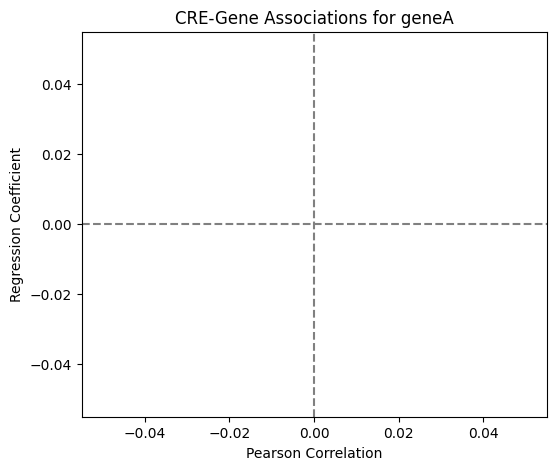

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Example: compute correlation for one gene
gene = "geneA"
gene_idx = gene_names_from_coefficients.index(gene)
# Assume gene expression is not y_all, but let's mock it as random for demonstration
# In practice, replace this with your actual gene expression vector for geneA
gene_expr = np.random.rand(X_abgd.shape[0])

# Align correlation values to CREs in coefficients
# X_abgd columns are features, coefficients columns are CREs (e.g., 'peak1', 'peak2', 'peak4')
# We'll only compute correlations for the CREs present in coefficients for this gene

cre_names = coefficients.columns
corrs = []
for cre in cre_names:
	if cre in X_abgd.columns:
		corr = stats.pearsonr(X_abgd[cre], gene_expr)[0]
	else:
		corr = np.nan  # or 0, if you prefer
	corrs.append(corr)
reg_coefs = coefficients.loc[gene, :].values

# Scatter: Regression Coef vs. Correlation
plt.figure(figsize=(6, 5))
sns.scatterplot(x=corrs, y=reg_coefs)
plt.xlabel("Pearson Correlation")
plt.ylabel("Regression Coefficient")
plt.title(f"CRE-Gene Associations for {gene}")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()


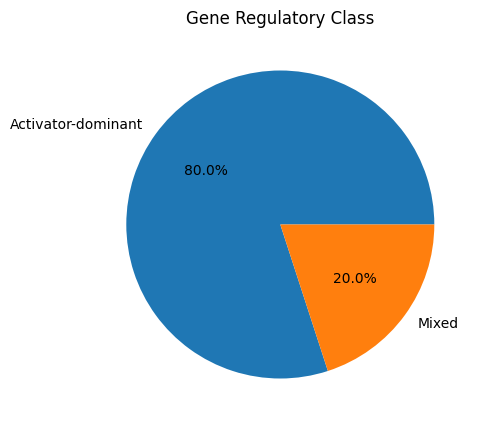


Gene Class Counts:
Activator-dominant    4
Mixed                 1
Name: count, dtype: int64


IndexError: Boolean index has wrong length: 25 instead of 3

In [12]:
#classify CREs based on regulatory mode, count of how many genes are predominantly regulated by act/rep
gene_classes = []

for index, coef_row in coefficients.iterrows(): # Iterate over rows, getting index and row as a Series
    # coef_row is now a pandas Series containing numerical values
    n_pos = np.sum(coef_row > 0)
    n_neg = np.sum(coef_row < 0)
    if n_pos > n_neg:
        gene_classes.append("Activator-dominant")
    elif n_neg > n_pos:
        gene_classes.append("Repressor-dominant")
    else:
        gene_classes.append("Mixed")

# Plot pie chart
gene_class_counts = pd.Series(gene_classes).value_counts()
gene_class_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel("")
plt.title("Gene Regulatory Class")
plt.show()

print("\nGene Class Counts:")
print(gene_class_counts)

dense_distance_matrix = sparse_distance_matrix.toarray()
promoter_distance_threshold = 2000 
is_promoter = (dense_distance_matrix < promoter_distance_threshold)
#promoter specific repression?
# If promoter CREs are defined by distance to TSS

# Check how many promoter CREs have negative coefficients
# Ensure is_promoter is a 1D boolean array matching number of columns (CREs)
is_promoter = is_promoter.flatten()  # or use .ravel()
promoter_coefs = coefficients.loc[:, is_promoter]
n_promoter_repressors = (promoter_coefs < 0).sum()


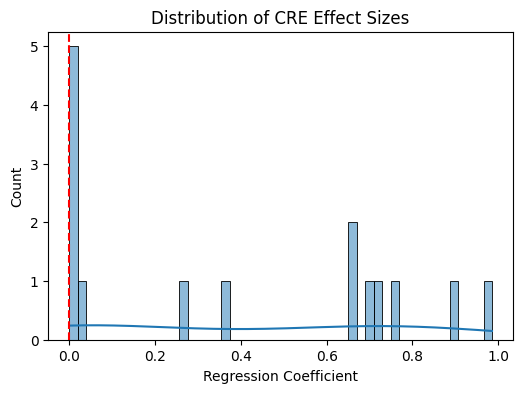

In [14]:
# identify activating and repressing cres, classify them based off regression coeff
# For all genes and CREs
all_coefs = coefficients.values.flatten()
plt.figure(figsize=(6, 4))
sns.histplot(all_coefs, bins=50, kde=True)
plt.xlabel("Regression Coefficient")
plt.title("Distribution of CRE Effect Sizes")
plt.axvline(0, color='red', linestyle='--')
plt.show()

#Bimodal or skewed distributions can suggest activator/repressor dynamics. Negative coefficients may indicate repressive CREs.


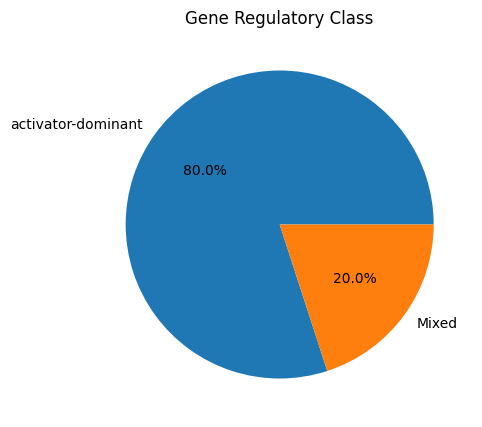

c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\scipy\sparse\_base.py:516: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  return self.tocsr().__lt__(other)


InvalidIndexError: (slice(None, None, None), <Compressed Sparse Row sparse matrix of dtype 'bool'
	with 25 stored elements and shape (5, 5)>)

In [19]:
#classify CREs based on regulatory mode, count of how many genes are predominantly regulated by act/rep
gene_classes = []

for row in coefficients.itertuples(index=False):
    values = np.array(row, dtype=float)
    n_pos = np.sum(values > 0)
    n_neg = np.sum(values < 0)
    gene_classes.append(
    "activator-dominant" if n_pos > n_neg else
    "repressor-dominant" if n_neg > n_pos else
    "Mixed"
)

# Plot pie chart
gene_class_counts = pd.Series(gene_classes).value_counts()
gene_class_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel("")
plt.title("Gene Regulatory Class")
plt.show()

#promoter specific repression?
# If promoter CREs are defined by distance to TSS
is_promoter = (sparse_distance_matrix < 2000)  # adjust as needed

# Check how many promoter CREs have negative coefficients
promoter_coefs = coefficients[:, is_promoter]
n_promoter_repressors = (promoter_coefs < 0).sum()


In [20]:
# distance of repressors vs activator reg elements
coef_signs = np.sign(coefficients.flatten())
distances = distance_matrix.flatten()

df = pd.DataFrame({
    "Coefficient Sign": coef_signs,
    "Distance": np.log10(distances + 1)
})
df["Type"] = df["Coefficient Sign"].map({-1: "Repressor", 1: "Activator", 0: "Neutral"})

sns.violinplot(data=df[df["Type"] != "Neutral"], x="Type", y="Distance")
plt.title("CRE Distance from TSS by Effect Type")
plt.ylabel("log10 Distance (bp)")
plt.show()
# Repressors may act from distal sites, consistent with 3D chromatin looping models.

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [ ]:
# cres with dual functions that activate some genes while repressing others
sign_matrix = np.sign(coefficients)
dual_CREs = []

for i in range(sign_matrix.shape[1]):  # for each CRE
    signs = sign_matrix[:, i]
    if np.any(signs > 0) and np.any(signs < 0):
        dual_CREs.append(i)

print(f"Found {len(dual_CREs)} dual-function CREs.")

# Plot: CRE vs. gene with signed effect
import plotly.express as px

# Create long-form DataFrame
rows = []
for gene_idx in range(coefficients.shape[0]):
    for cre_idx in dual_CREs:
        coef = coefficients[gene_idx, cre_idx]
        if coef != 0:
            rows.append({
                "Gene": gene_names[gene_idx],
                "CRE": cre_names[cre_idx],
                "Effect": coef
            })

df_dual = pd.DataFrame(rows)
fig = px.scatter(df_dual, x="CRE", y="Gene", color="Effect", color_continuous_scale="RdBu")
fig.update_layout(title="Dual-function CREs")
fig.show()

#Such context-dependent CREs may interact with lineage-specific TFs or chromatin states.


In [ ]:
#cluster cres by effect direction (compare clustering by raw 
# accessibility vs. regulatory influence) 

# 1. Cluster by accessibility
X_cre_scaled = StandardScaler().fit_transform(X.T)
pca_acc = PCA(n_components=10).fit_transform(X_cre_scaled)

# 2. Cluster by regression coefficients
coefs_cre_scaled = StandardScaler().fit_transform(coefficients.T)
pca_coef = PCA(n_components=10).fit_transform(coefs_cre_scaled)

# Plot t-SNE
tsne_acc = TSNE(n_components=2).fit_transform(pca_acc)
tsne_coef = TSNE(n_components=2).fit_transform(pca_coef)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(tsne_acc[:, 0], tsne_acc[:, 1], alpha=0.7)
ax[0].set_title("CREs Clustered by Accessibility")
ax[1].scatter(tsne_coef[:, 0], tsne_coef[:, 1], alpha=0.7, color='orange')
ax[1].set_title("CREs Clustered by Regulatory Influence")
plt.show()

#Functional CRE clustering based on gene-level influence may reveal 
# co-regulated elements or modules not apparent from accessibility alone.